## Блок 1: Импорты

In [16]:
import os
import time
import pandas as pd
import yfinance as yf
from tqdm import tqdm
import zipfile
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

## Блок 2: Конфигурация

In [2]:
DATA_DIR = "full_history/full_history"
NEWS_FILES = ["All_external.csv", "nasdaq_exteral_data.csv"]
META_CACHE = "ticker_meta_yahoo.csv"

START_DATE = pd.to_datetime("2019-01-01")
END_DATE = pd.to_datetime("2023-12-31")
TRADING_DAYS_EXPECTED = 252 * 5

THRESHOLD_PRICE_ROWS = 1000
THRESHOLD_NEWS_COUNT = 50
THRESHOLD_COVERAGE_PCT = 80

pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

BASE_URL = "https://huggingface.co/datasets/Zihan1004/FNSPID/resolve/main"
CHUNKSIZE = 200_000

## Блок 3: Вспомогательные функции

In [3]:
def download_file(url, filename):
    print(f"Скачиваю {filename}...")
    resp = requests.get(url, stream=True)
    resp.raise_for_status()
    total_size = int(resp.headers.get('content-length', 0))
    with open(filename, "wb") as f:
        with tqdm(total=total_size, unit='B', unit_scale=True, unit_divisor=1024) as pbar:
            for chunk in resp.iter_content(1024 * 1024):
                if chunk:
                    f.write(chunk)
                    pbar.update(len(chunk))
    print(f"Готово: {filename}")


def normalize_ticker_for_yahoo(ticker):
    return str(ticker).replace(".", "-").strip()


def get_company_metadata(ticker):
    symbol = normalize_ticker_for_yahoo(ticker)
    try:
        info = yf.Ticker(symbol).get_info()
        return {
            "ticker": str(ticker),
            "yahoo_symbol": symbol,
            "company_name": info.get("longName") or info.get("shortName"),
            "sector": info.get("sector"),
            "industry": info.get("industry"),
            "exchange": info.get("exchange"),
            "quoteType": info.get("quoteType")
        }
    except Exception:
        return {
            "ticker": str(ticker), "yahoo_symbol": symbol,
            "company_name": None, "sector": None, "industry": None,
            "exchange": None, "quoteType": None
        }
    finally:
        time.sleep(0.25)


def load_or_create_meta_cache(path):
    if os.path.exists(path) and os.path.getsize(path) > 0:
        try:
            return pd.read_csv(path)
        except Exception:
            pass
    return pd.DataFrame(columns=[
        "ticker", "yahoo_symbol", "company_name", 
        "sector", "industry", "exchange", "quoteType"
    ])


def fetch_missing_metadata(tickers, cache_path):
    cache = load_or_create_meta_cache(cache_path)
    cached_tickers = set(cache["ticker"].astype(str))
    missing = [t for t in tickers if str(t) not in cached_tickers]
    print(f"[META] Cached: {len(cached_tickers)}, Need to fetch: {len(missing)}")
    if missing:
        new_records = [get_company_metadata(t) for t in tqdm(missing, desc="Yahoo meta")]
        cache = pd.concat([cache, pd.DataFrame(new_records)], ignore_index=True)
        cache = cache.drop_duplicates(subset=["ticker"], keep="last")
        cache.to_csv(cache_path, index=False)
        print(f"[META] Cache saved: {cache_path}")
    return cache


def aggregate_news_statistics(file_paths, valid_tickers, chunksize=200_000):
    counts, min_dates, max_dates = {}, {}, {}
    for filepath in file_paths:
        for chunk in tqdm(pd.read_csv(filepath, chunksize=chunksize, low_memory=False),
                         desc=f"Processing {os.path.basename(filepath)}"):
            chunk = chunk.rename(columns={"Date": "date", "Stock_symbol": "ticker"})
            if "date" not in chunk.columns or "ticker" not in chunk.columns:
                continue
            chunk["date"] = pd.to_datetime(chunk["date"], errors="coerce", utc=True).dt.tz_convert(None)
            chunk = chunk.dropna(subset=["date", "ticker"])
            chunk = chunk[(chunk["date"] >= START_DATE) & (chunk["date"] <= END_DATE)]
            chunk["ticker"] = chunk["ticker"].astype(str)
            chunk = chunk[chunk["ticker"].isin(valid_tickers)]
            if chunk.empty:
                continue
            grouped = chunk.groupby("ticker")["date"].agg(["count", "min", "max"])
            for ticker, row in grouped.iterrows():
                counts[ticker] = counts.get(ticker, 0) + int(row["count"])
                min_dates[ticker] = row["min"] if ticker not in min_dates else min(min_dates[ticker], row["min"])
                max_dates[ticker] = row["max"] if ticker not in max_dates else max(max_dates[ticker], row["max"])
    return pd.DataFrame({
        "ticker": list(counts.keys()),
        "news_count": [counts[t] for t in counts],
        "news_min_date": [min_dates[t] for t in counts],
        "news_max_date": [max_dates[t] for t in counts]
    })


def analyze_price_coverage(data_dir, start, end, expected_days):
    files = [f for f in os.listdir(data_dir) if f.endswith(".csv")]
    results = []
    for filename in tqdm(files, desc="Analyzing prices"):
        ticker = filename[:-4]
        try:
            df = pd.read_csv(os.path.join(data_dir, filename), low_memory=False)
            df = df.rename(columns={"Date": "date"})
            if "date" not in df.columns:
                continue
            df["date"] = pd.to_datetime(df["date"], errors="coerce")
            df = df.dropna(subset=["date"])
            df = df[(df["date"] >= start) & (df["date"] <= end)]
            if df.empty:
                continue
            date_min, date_max = df["date"].min(), df["date"].max()
            coverage = len(df) / expected_days * 100
            starts_ok = date_min.year == 2019 and date_min.month <= 3
            ends_ok = date_max.year == 2023 and date_max.month >= 10
            results.append({
                "ticker": ticker,
                "price_rows": len(df),
                "price_min_date": date_min,
                "price_max_date": date_max,
                "coverage_pct": round(coverage, 1),
                "starts_in_2019": starts_ok,
                "ends_in_2023": ends_ok,
                "full_coverage": starts_ok and ends_ok
            })
        except Exception:
            continue
    return pd.DataFrame(results)


def apply_quality_filters(df, min_rows, min_news, min_coverage):
    return (
        (df["full_coverage"] == True) &
        (df["price_rows"] >= min_rows) &
        (df["news_count"] >= min_news) &
        (df["coverage_pct"] >= min_coverage)
    )


def print_summary(df, title):
    print(f"\n{'='*60}")
    print(title)
    print('='*60)
    print(f"Total companies: {len(df)}")
    print(f"Period: {START_DATE.date()} — {END_DATE.date()}")
    if len(df) > 0:
        print(f"\nPrice data points - Mean: {df['price_rows'].mean():.0f}")
        print(f"News articles - Mean: {df['news_count'].mean():.0f}, "
              f"Median: {df['news_count'].median():.0f}, "
              f"Range: [{df['news_count'].min()}, {df['news_count'].max()}]")

## Блок 4: Скачивание данных

In [4]:
news_files_download = {
    "All_external.csv": "Stock_news/All_external.csv",
    "nasdaq_exteral_data.csv": "Stock_news/nasdaq_exteral_data.csv",
}

for local_name, remote_path in news_files_download.items():
    download_file(f"{BASE_URL}/{remote_path}", local_name)

zip_filename = "full_history.zip"
download_file(f"{BASE_URL}/Stock_price/full_history.zip", zip_filename)

print("Распаковываю full_history.zip...")
with zipfile.ZipFile(zip_filename, "r") as z:
    z.extractall("full_history")
print("Готово: данные распакованы в full_history/")

Скачиваю All_external.csv...


100%|████████████████████████████████████| 5.34G/5.34G [42:27<00:00, 2.25MB/s]


Готово: All_external.csv
Скачиваю nasdaq_exteral_data.csv...


100%|██████████████████████████████████| 21.6G/21.6G [2:33:15<00:00, 2.53MB/s]


Готово: nasdaq_exteral_data.csv
Скачиваю full_history.zip...


100%|██████████████████████████████████████| 562M/562M [03:34<00:00, 2.75MB/s]


Готово: full_history.zip
Распаковываю full_history.zip...
Готово: данные распакованы в full_history/


## Блок 5: Основной пайплайн

In [5]:
print("="*60)
print("STEP 1: Analyzing price data coverage (2019-2023)")
print("="*60)

price_data = analyze_price_coverage(
    DATA_DIR, START_DATE, END_DATE, TRADING_DAYS_EXPECTED
)
print(f"Tickers with price data: {len(price_data)}")
print(f"Full coverage (2019-2023): {price_data['full_coverage'].sum()}")

print("\n" + "="*60)
print("STEP 2: Aggregating news statistics (2019-2023)")
print("="*60)

valid_tickers = set(price_data["ticker"].astype(str))
news_data = aggregate_news_statistics(NEWS_FILES, valid_tickers)
print(f"Tickers with news: {len(news_data)}")

print("\n" + "="*60)
print("STEP 3: Merging and filtering data")
print("="*60)

combined = price_data.merge(news_data, on="ticker", how="inner")
combined["passes_filters"] = apply_quality_filters(
    combined, THRESHOLD_PRICE_ROWS, THRESHOLD_NEWS_COUNT, THRESHOLD_COVERAGE_PCT
)

print(f"Tickers with both sources: {len(combined)}")
print(f"Pass all quality filters: {combined['passes_filters'].sum()}")

print("\n" + "="*60)
print("STEP 4: Enriching with company metadata")
print("="*60)

filtered = combined[combined["passes_filters"]].sort_values("news_count", ascending=False)
metadata = fetch_missing_metadata(filtered["ticker"].tolist(), META_CACHE)

final_dataset = filtered.merge(
    metadata[["ticker", "company_name", "sector", "industry", "exchange", "quoteType"]],
    on="ticker", how="left"
)

output_columns = [
    "ticker", "company_name", "sector", "industry", "exchange", "quoteType",
    "price_rows", "price_min_date", "price_max_date", "coverage_pct",
    "starts_in_2019", "ends_in_2023", "full_coverage",
    "news_count", "news_min_date", "news_max_date"
]
final_dataset = final_dataset[output_columns].reset_index(drop=True)

STEP 1: Analyzing price data coverage (2019-2023)


Analyzing prices: 100%|██████████████████| 7693/7693 [00:27<00:00, 281.48it/s]


Tickers with price data: 7691
Full coverage (2019-2023): 4114

STEP 2: Aggregating news statistics (2019-2023)


Processing All_external.csv: 66it [00:56,  1.18it/s]
Processing nasdaq_exteral_data.csv: 78it [02:25,  1.86s/it]

Tickers with news: 5790

STEP 3: Merging and filtering data
Tickers with both sources: 5790
Pass all quality filters: 2977

STEP 4: Enriching with company metadata
[META] Cached: 2977, Need to fetch: 0


## Блок 6: Сохранение результатов

In [6]:
print("\n" + "="*60)
print("STEP 5: Saving results")
print("="*60)

final_dataset.to_csv("selected_companies_2019_2023.csv", index=False)
print("✓ selected_companies_2019_2023.csv")

equities = final_dataset[final_dataset["quoteType"] == "EQUITY"].copy()
equities.to_csv("selected_equities_only_2019_2023.csv", index=False)
print(f"✓ selected_equities_only_2019_2023.csv ({len(equities)} equities)")

pd.DataFrame({"ticker": final_dataset["ticker"]}).to_csv("selected_tickers.csv", index=False)
print("✓ selected_tickers.csv")

print_summary(final_dataset, "FINAL DATASET SUMMARY")

print(f"\nBy instrument type:")
print(final_dataset["quoteType"].value_counts().to_string())

print(f"\nBy sector (top 10):")
print(final_dataset["sector"].value_counts().head(10).to_string())

print(f"\nBy exchange:")
print(final_dataset["exchange"].value_counts().to_string())

print("\n" + "="*60)
print("TOP 10 COMPANIES BY NEWS COVERAGE:")
print("="*60)
display_cols = ["ticker", "company_name", "sector", "exchange", "price_rows", "news_count"]
print(final_dataset[display_cols].head(10).to_string(index=False))


STEP 5: Saving results
✓ selected_companies_2019_2023.csv
✓ selected_equities_only_2019_2023.csv (2206 equities)
✓ selected_tickers.csv

FINAL DATASET SUMMARY
Total companies: 2977
Period: 2019-01-01 — 2023-12-31

Price data points - Mean: 1256
News articles - Mean: 673, Median: 296, Range: [50, 12462]

By instrument type:
quoteType
EQUITY        2206
ETF            514
NONE           217
MUTUALFUND       1

By sector (top 10):
sector
Financial Services        516
Healthcare                306
Industrials               283
Technology                274
Consumer Cyclical         228
Energy                    129
Real Estate               119
Basic Materials           107
Consumer Defensive         93
Communication Services     83

By exchange:
exchange
NYQ    1124
NMS     612
PCX     364
NGM     266
NCM     212
ASE      71
BTS      43
PNK      20
OQB       6
OQX       3

TOP 10 COMPANIES BY NEWS COVERAGE:
ticker                                             company_name                 s

## Блок 7: Параметры для построения графиков

In [17]:
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

companies = pd.read_csv("selected_equities_only_2019_2023.csv").copy()

for col in ["price_min_date", "price_max_date", "news_min_date", "news_max_date"]:
    if col in companies.columns:
        companies[col] = pd.to_datetime(companies[col], errors="coerce")

### График 1: Распределение по секторам

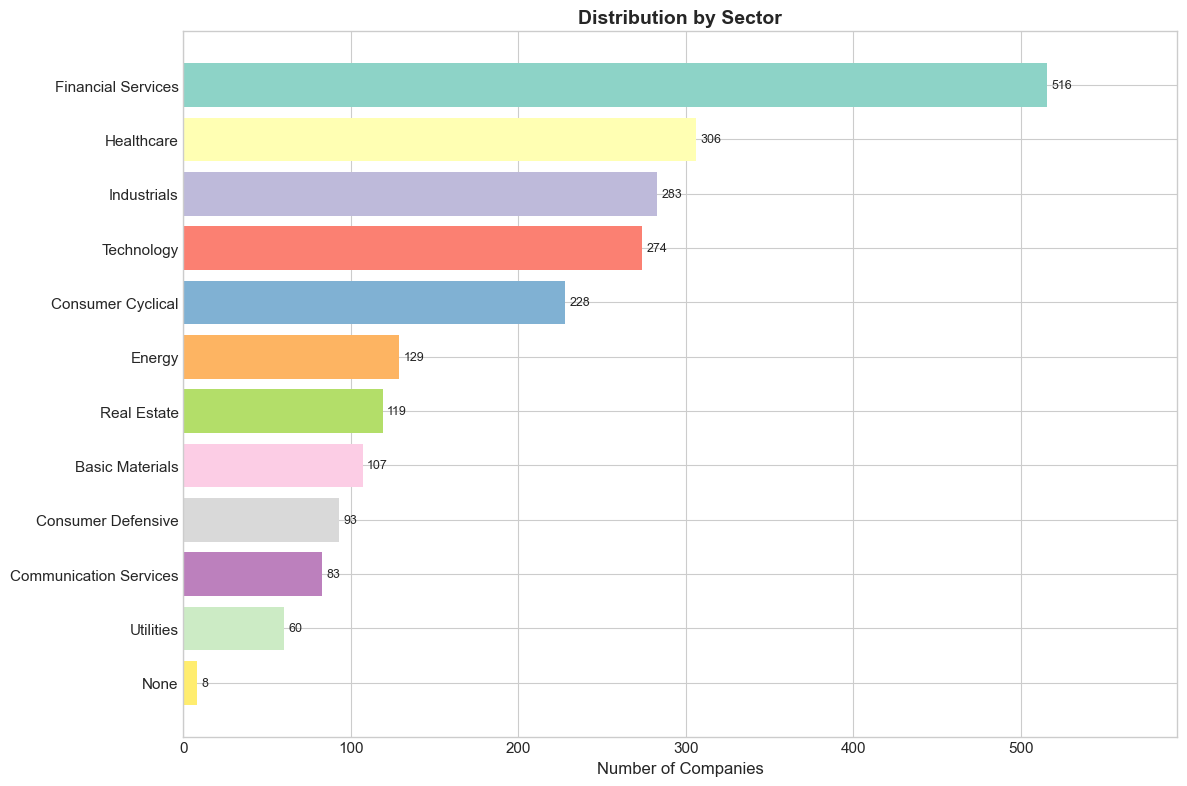

In [19]:
fig, ax = plt.subplots(figsize=(12, 8))
sector_counts = companies['sector'].fillna('None').value_counts()
colors_sector = plt.cm.Set3(np.linspace(0, 1, len(sector_counts)))

bars = ax.barh(sector_counts.index[::-1], sector_counts.values[::-1], color=colors_sector[::-1])
ax.set_xlabel('Number of Companies')
ax.set_title('Distribution by Sector', fontweight='bold')
ax.bar_label(bars, padding=3, fontsize=9)
ax.set_xlim(0, max(sector_counts.values) * 1.15)

plt.tight_layout()
plt.show()

### График 2: Распределение количества новостей по компаниям

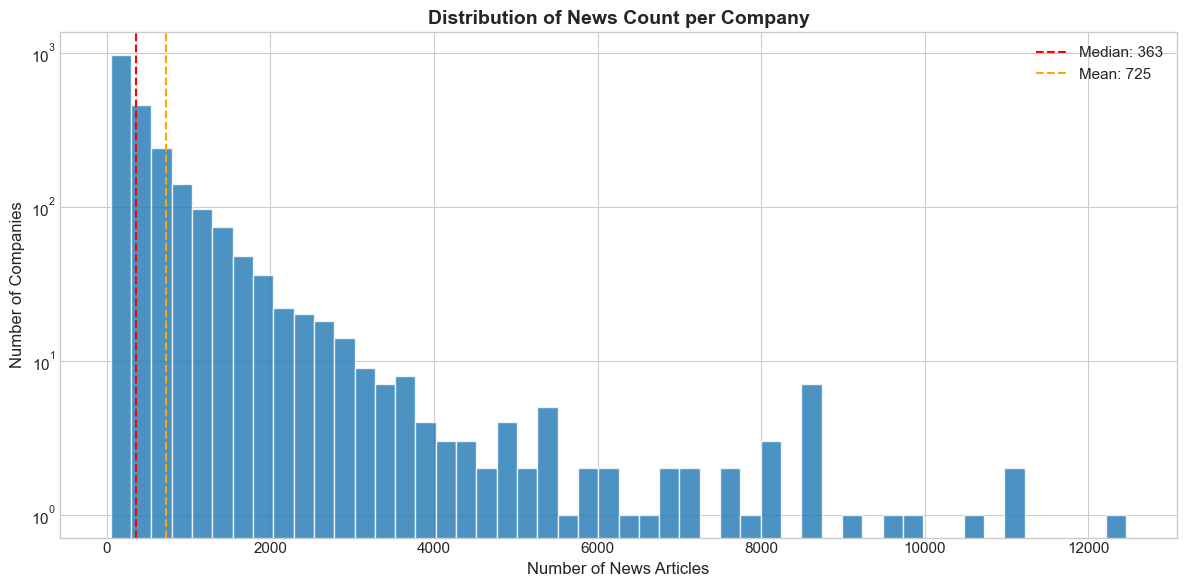

In [23]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(companies['news_count'], bins=50, edgecolor='white', alpha=0.8)

ax.axvline(companies['news_count'].median(), color='red', linestyle='--',
           label=f'Median: {companies["news_count"].median():.0f}')
ax.axvline(companies['news_count'].mean(), color='orange', linestyle='--',
           label=f'Mean: {companies["news_count"].mean():.0f}')

ax.set_xlabel('Number of News Articles')
ax.set_ylabel('Number of Companies')
ax.set_title('Distribution of News Count per Company', fontweight='bold')
ax.legend()
ax.set_yscale('log')

plt.tight_layout()
plt.show()

### График 3: Топ-30 компаний по освещению в новостях

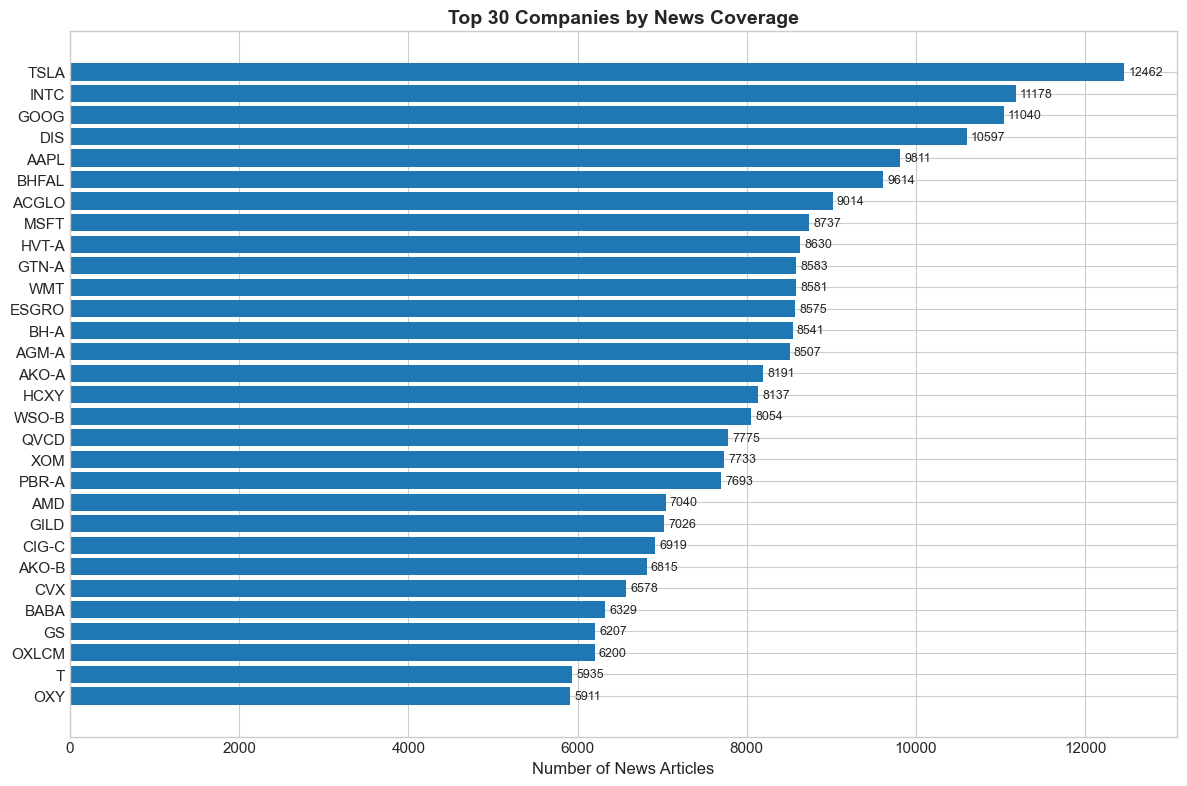

In [26]:
fig, ax = plt.subplots(figsize=(12, 8))
top30 = companies.nlargest(30, 'news_count')[['ticker', 'news_count']]
bars = ax.barh(range(len(top30)), top30['news_count'].values)

ax.set_yticks(range(len(top30)))
ax.set_yticklabels(top30['ticker'].values)
ax.set_xlabel('Number of News Articles')
ax.set_title('Top 30 Companies by News Coverage', fontweight='bold')
ax.invert_yaxis()
ax.bar_label(bars, padding=3, fontsize=9)

plt.tight_layout()
plt.show()

### График 4: Распространение новостей по секторам (Топ-10)

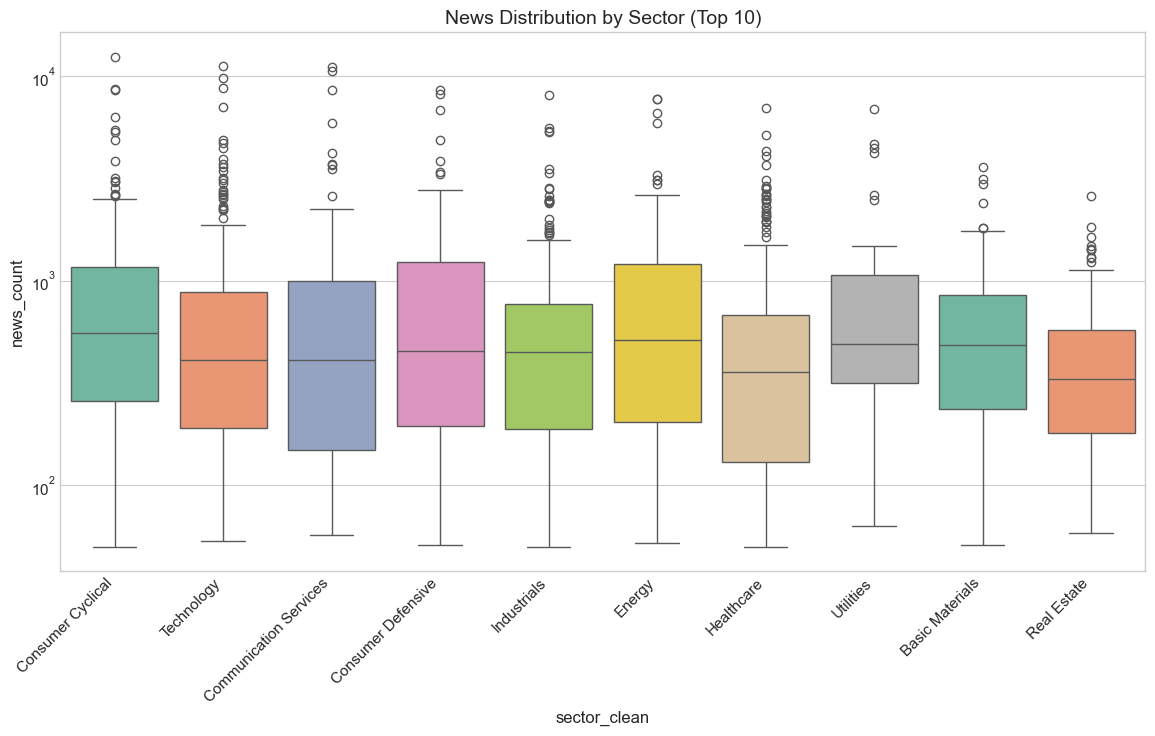

In [41]:
fig, ax = plt.subplots(figsize=(14, 7))

companies_plot = companies.copy()
companies_plot["sector_clean"] = companies_plot["sector"].fillna("Unknown")

tmp = companies_plot[companies_plot["sector_clean"] != "Unknown"]
sector_order = tmp.groupby("sector_clean")["news_count"].median().sort_values(ascending=False).index

top10 = sector_order[:10]
companies_plot = companies_plot[companies_plot["sector_clean"].isin(top10)]

sns.boxplot(data=companies_plot, x="sector_clean", y="news_count", palette="Set2")
plt.xticks(rotation=45, ha="right")
plt.yscale("log")
plt.title("News Distribution by Sector (Top 10)")
plt.show()

### График 5: Cоотношение ценового охвата и объема новостей

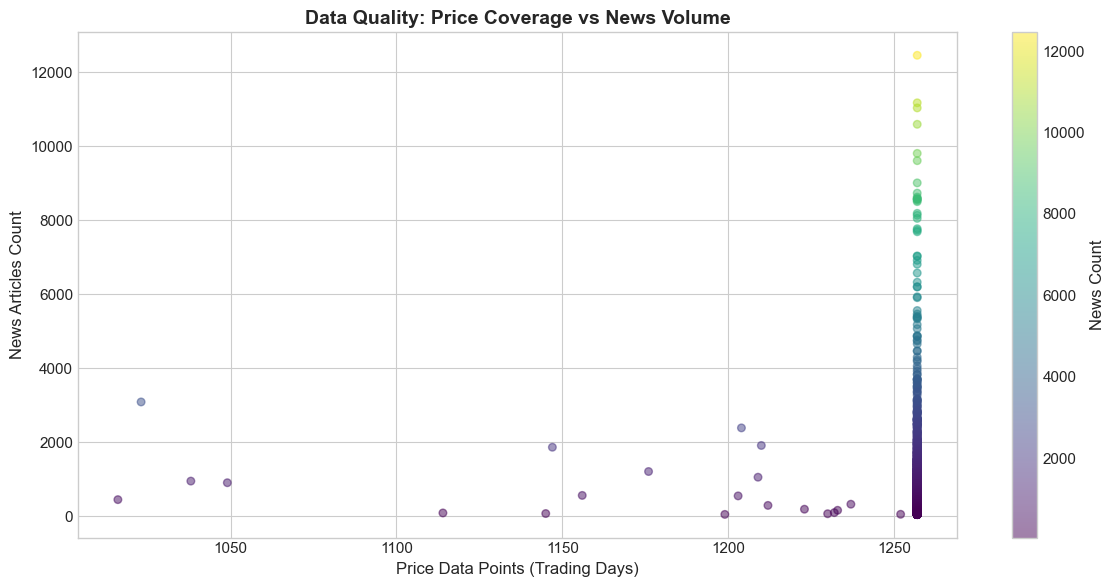

In [31]:
fig, ax = plt.subplots(figsize=(12, 6))
sc = ax.scatter(companies['price_rows'], companies['news_count'],
                alpha=0.5, c=companies['news_count'], cmap='viridis', s=30)

ax.set_xlabel('Price Data Points (Trading Days)')
ax.set_ylabel('News Articles Count')
ax.set_title('Data Quality: Price Coverage vs News Volume', fontweight='bold')
plt.colorbar(sc, ax=ax, label='News Count')

plt.tight_layout()
plt.show()

### Парето-анализ: концентрация новостей среди компаний

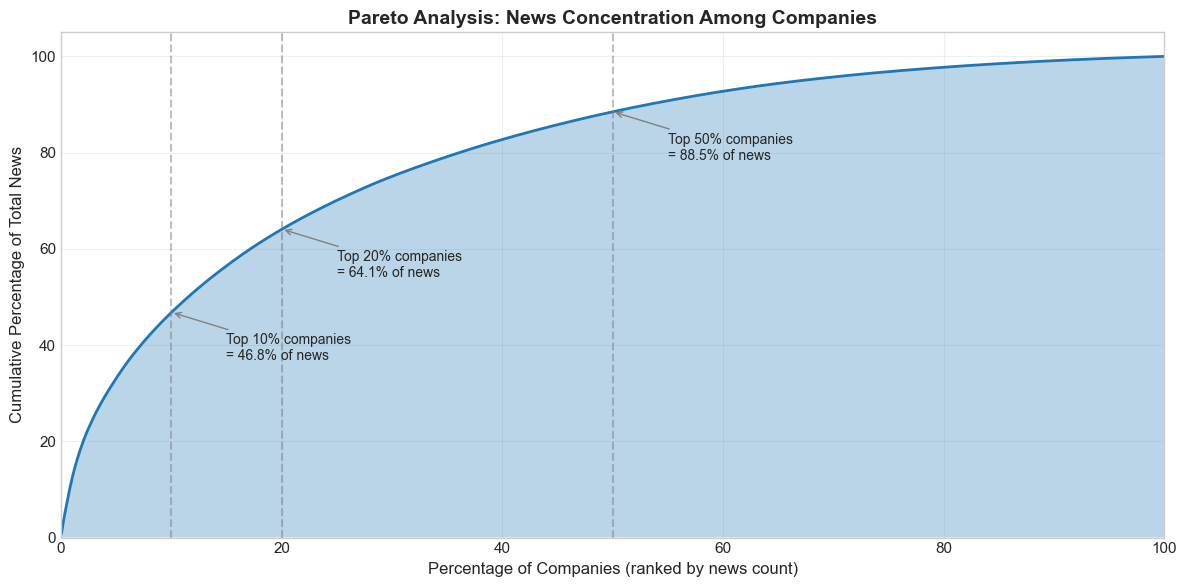

In [36]:
fig, ax = plt.subplots(figsize=(12, 6))
sorted_news = np.sort(companies['news_count'].values)[::-1]
cumsum = np.cumsum(sorted_news)
cumsum_pct = cumsum / cumsum[-1] * 100
companies_pct = np.arange(1, len(sorted_news) + 1) / len(sorted_news) * 100

ax.plot(companies_pct, cumsum_pct, linewidth=2)
ax.fill_between(companies_pct, cumsum_pct, alpha=0.3)

for pct in [10, 20, 50]:
    idx = int(len(sorted_news) * pct / 100)
    ax.axvline(pct, color='gray', linestyle='--', alpha=0.5)
    ax.annotate(f'Top {pct}% companies\n= {cumsum_pct[idx]:.1f}% of news',
                xy=(pct, cumsum_pct[idx]),
                xytext=(pct+5, max(5, cumsum_pct[idx]-10)),
                fontsize=10,
                arrowprops=dict(arrowstyle='->', color='gray'))

ax.set_xlabel('Percentage of Companies (ranked by news count)')
ax.set_ylabel('Cumulative Percentage of Total News')
ax.set_title('Pareto Analysis: News Concentration Among Companies', fontsize=14, fontweight='bold')
ax.set_xlim(0, 100)
ax.set_ylim(0, 105)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Сводная статистика набора данных

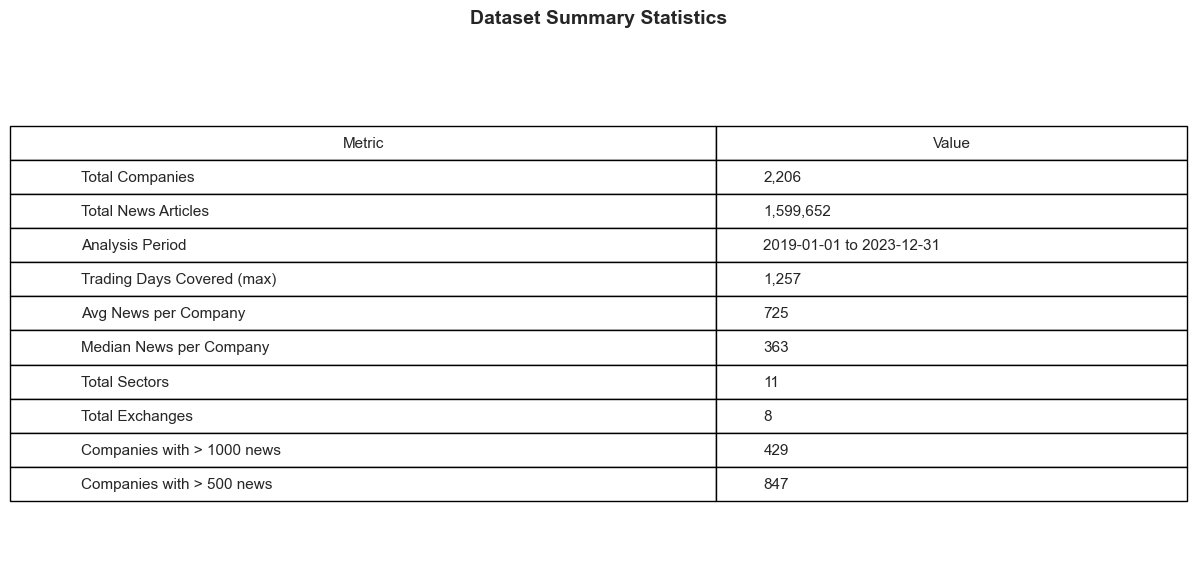

In [37]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('off')

summary_data = [
    ['Total Companies', f'{len(companies):,}'],
    ['Total News Articles', f'{companies["news_count"].sum():,}'],
    ['Analysis Period', '2019-01-01 to 2023-12-31'],
    ['Trading Days Covered (max)', f'{companies["price_rows"].max():,}'],
    ['Avg News per Company', f'{companies["news_count"].mean():,.0f}'],
    ['Median News per Company', f'{companies["news_count"].median():,.0f}'],
    ['Total Sectors', f'{companies["sector"].nunique()}'],
    ['Total Exchanges', f'{companies["exchange"].nunique()}'],
    ['Companies with > 1000 news', f'{(companies["news_count"] > 1000).sum():,}'],
    ['Companies with > 500 news', f'{(companies["news_count"] > 500).sum():,}']
]

table = ax.table(cellText=summary_data,
                 colLabels=['Metric', 'Value'],
                 cellLoc='left', loc='center',
                 colWidths=[0.6, 0.4])

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.8)
ax.set_title('Dataset Summary Statistics', fontweight='bold', pad=20)

plt.tight_layout()
plt.show()